# QQQ/SCHD **동적** 자산분배 포트폴리오 수익률 분석 백테스팅

### 동적자산분배로 주가가 오르는 추세면 더 많이 사고 떨어지면 비중을 줄이면서 CAGR은 더 높이고, MDD는 더 낮출 수 있는지 확인하고자 한다.

- QQQ(ETF) : 나스닥 상장주 중 금융주 제외 상위 100종목을 추종

- SCHD(ETF) : 다우존스 Dividend 100 INDEX를 기초자산으로 추종(배당금 지급 미국 주식 100개의 시총 지수 추종)

- CAGR 및 MDD : 연평균 성장률 / 최대 낙폭

<br>

### 2011/11 ~ 2024/07 QQQ + SCHD 분할매수 백테스팅

- 동적자산분배 기법 적용 시 수익률 분석

> Reference : https://dotsnlines.tistory.com/1107

<br>

### 조건
1. QQQ와 SCHD를 ***평균모멘텀스코어***를 통해 비중을 매월 리밸런싱한다.(기존 정적자산분배 시 8:2 ~ 2:8로 수행함)
2. 초기자산은 100,000,000원 = 약 73,000달러이며 매월 1,000,000원 = 약 730달러씩 추가금을 투입한다. (리밸런싱은 추가금이 투입된 기준으로 수행됨)
3. 배당수익은 재투자를 가정한다.
4. 매매수수료 0.25%, 배당소득세 15.4%를 반영한다.
5. 기간은 QQQ와 SCHD 중 상장일이 더 늦은 자산을 기준으로(데이터 로딩 이슈) 2024/7/31(7월 마지막 영업일) 까지로 설정됐다.
6. 연도별 손익을 합쳐서 250만원이 넘는 금액에 대해서는 22% 세금(= 양도소득세, 미국 ETF)을 제하고 마지막 날 자산을 조정한다.

<br>

### 평균 모멘텀 스코어
- 주식에도 관성이 있다고 가정하고, 주식이 오를 때는 비중을 증가시키고 / 떨어질 때는 비중을 감소시키는 방법이다.

- 과거 12개월동안의 주가변화를 계산하여 올랐을 때는 1 / 내렸을 때는 0을 부여한다. -> 합계를 12로 나눠주면 그 값이 자산의 비중이 된다.

- 매월 평균모멘텀스코어를 계산하기 때문에 매월 분할비중이 달라지게 된다.

---

---

---

## I. 필요 라이브러리 호출 및 함수 정의, 초기 세팅

### 라이브러리 호출

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from datetime import datetime
pd.options.display.float_format = '{:,.2f}'.format

### 초기 세팅

In [2]:
# - - - Parameters - - - - -
p1 = 'QQQ' ; p2 = 'SCHD'

p1비율 = 0.5 # 초기(약 1억 원) 투자자산 배분비율, 이후 평균모멘텀스코어에 따른 동적배분 시행

매매수수료 = 0.0025 # (0.25%)
배당소득세 = 0.154 # (15.4%)
연간양도세율 = 0.22
양도소득세적용여부 = 1

moment_months = 12 # 모멘텀 계산 주기설정(12개월 = 1년)

start = datetime(2011, 1, 1)
end = datetime(2024, 8, 1)

초기투자금 = int(100000000 / 1150) # 분석 시작일인 2011년 11월 초 환율 약 1150원을 반영
매월투자금 = int(1000000 / 1150)

### 각 ticker의 배당금($) 구하는 메소드

In [3]:
def get_div(p):
    ticker = yf.Ticker(p)
    div = ticker.dividends.tz_localize(None)
    return div

### 각 ETF의 주가, 환율을 데이터프레임화하는 메소드

In [4]:
def get_data(p1, p2, start, end):
    df1 = yf.download(p1, start, end)
    df1.rename(columns = {'Adj Close' : 'QQQ 주가'}, inplace = True)

    df2 = yf.download(p2, start, end)
    df2.rename(columns = {'Adj Close' : 'SCHD 주가'}, inplace = True)

    df_ex = yf.download('KRW=X', start, end) # 환율 데이터 추가(연도별 환율 변동 고려)
    df_ex.rename(columns = {'Adj Close' : '환율'}, inplace = True)

    df = pd.merge(df1['QQQ 주가'], df2['SCHD 주가'], left_index = True, right_index = True, how = 'inner')
    df = pd.merge(df, df_ex['환율'], left_index = True, right_index = True)

    return df

### QQQ, SCHD 데이터프레임 생성 및 배당금 concat 메소드
- 배당금 적용 가정
- 기 정의한 메소드들(get_data, get_div) 사용, 최종 데이터프레임 도출

In [5]:
def merge_div(p1, p2, start, end):
    df = get_data(p1, p2, start, end)
    div1 = get_div(p1)
    div2 = get_div(p2)

    df['QQQ 배당금'] = div1
    df['SCHD 배당금'] = div2

    df.fillna(0, inplace = True) # 배당금 미지급일의 NaN 표시(결측치)를 0으로 대치

    return df

### 월말 날짜만 가져오는 메소드(평균 모멘텀 스코어 도출 시 사용)

In [6]:
def get_monthly_end(df_d):
    df_copy = df_d.copy() # shallow copy 방지를 위한 copy() 메소드 사용
    df_copy['Odate'] = df_copy.index
    df = df_copy.groupby(by = [df_copy.index.year, df_copy.index.month]).last()
    df.set_index('Odate', inplace = True)
    return df

### 평균 모멘텀 스코어 구하는 메소드
- 실제투자금 합계 x 평균모멘텀스코어(0 ~ 1) 만큼 QQQ에 투자
- 실제투자금합계 x (1 - 평균모멘텀스코어) = 실제투자금합계 - QQQ투자금 만큼 SCHD에 투자

In [7]:
def momentum_score(df_d, moment_months):
    mm = int(moment_months)
    df = get_monthly_end(df_d)
    li_score = []
    li_tscore = [] # 현금 제외 자산의 합에 대한 비율

    for i in range(len(df)): # 한 달 단위로 모멘텀스코어 도출하기
        if i < mm - 1:
            li_score.append(0)
            li_tscore.append(0)

        else:
            tval = 0
            val = 0

            for m in range(1, mm + 1):
                if ((df['QQQ 주가'].iloc[i] + df['SCHD 주가'].iloc[i]) - (df['QQQ 주가'].iloc[i - 1] + df['SCHD 주가'].iloc[i - 1])) > 0:
                    tval += 1

                if (df['QQQ 주가'].iloc[i] - df['QQQ 주가'].iloc[i - m]) > 0:
                    val += 1 # 합계 x 평균모멘텀스코어 만큼 QQQ에 투자, 합계 x (1 - 평균모멘텀스코어) 만큼 SCHD에 투자

            li_score.append(val / mm)
            li_tscore.append(tval / mm)

    df['투자모멘텀스코어'] = li_tscore
    df['평균모멘텀스코어'] = li_score
    df = df[['투자모멘텀스코어', '평균모멘텀스코어']]
    return df

### MDD, CAGR 구하는 메소드

In [8]:
def get_mdd(col):
    window = 252 # (1년 = 영업일 기준 252일로 고려)

    # col의 각 시점에서 과거 252일동안의 최고점 계산
    # min_periods = 1은 최소 기간을 1일로 설정하여, 초기 몇 기간 동안 데이터가 불충분할 때도 계산가능하도록 함
    peak = col.rolling(window, min_periods = 1).max()

    # 각 시점에서의 최고점 대비 현재 가격이 얼마나 하락했는지를 백분율로 나타냄
    drawdown = col / peak - 1

    # 과거 252일 동안의 drawdown 최솟값(최대 하락률) 계산
    연도별mdd = drawdown.rolling(window, min_periods = 1).min()
    # "전체 기간" 고려한 최종 mdd 리턴
    mdd = 연도별mdd.min()
    return mdd

def get_cagr(df, col):
    start_value = df[col].iloc[0]
    end_value = df[col].iloc[-1]
    num_years = df.index[-1].year - df.index[0].year

    cagr = (end_value / start_value) ** (1 / num_years) - 1 # CAGR 공식
    return cagr

---

---

---

## II. main() 소스코드 : 실제 분석 진행 섹션


### 1. 세금 계산을 위해 년도 별 마지막 날 구하기
- df_y : li_lastdays(년도별 마지막 날이 담긴 리스트) 생성을 위한 temp df

In [9]:
df_y = get_data(p1, p2, start, end)
df_y['date'] = df_y.index
df_y = df_y.groupby(by = df_y.index.year).last() # 매년 마지막 날(year에 last() 메소드 적용)로 grouping

li_lastdays = df_y['date'].to_list() # 날짜 컬럼을 리스트화

print('\n', li_lastdays[0], li_lastdays[-1])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


 2011-12-30 00:00:00 2024-07-31 00:00:00


### 2. QQQ / SCHD 주가, 환율, 배당금 데이터를 데이터프레임으로 불러들이기

In [10]:
df = merge_div(p1, p2, start, end)
print(df.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


            QQQ 주가  SCHD 주가       환율  QQQ 배당금  SCHD 배당금
Date                                                   
2011-10-20   50.32    16.85 1,133.60     0.00      0.00
2011-10-21   50.95    17.18 1,137.30     0.00      0.00
2011-10-24   52.00    17.27 1,148.40     0.00      0.00
2011-10-25   50.98    16.99 1,132.80     0.00      0.00
2011-10-26   50.92    17.16 1,131.10     0.00      0.00


### 3. 월말투자금 넣기, 투자금 column을 데이터프레임에 추가
- df_m : 월말투자를 고려해서 li_monthlast 리스트로 매월 마지막 날을 추출하기 위한 temp df

In [11]:
# 월말투자금 넣기 위한 월말 정보 리스트 생성
df_m = df.copy() # shallow copy 방지를 위한 copy() 메소드 사용이 필수임.
df_m['date'] = df_m.index
df_m = df_m.groupby(by = [df.index.year, df.index.month]).last() # 매월 마지막 날만 필터링

li_monthlast = df_m['date'].to_list() # 리스트화(매월 마지막날이 저장됨)

print(li_monthlast[0]) ; print(li_monthlast[len(li_monthlast) - 1]) # 시작월 / 종료월 월말 리스트 원소 확인

2011-10-31 00:00:00
2024-07-31 00:00:00


In [12]:
# 투자금 column 데이터프레임에 추가
df['투자금'] = 0 # 투자금 열 추가 생성 및 초기화

for i, m in enumerate(li_monthlast):
    if i == 0:
        df.loc[m, '투자금'] = 초기투자금 # 1억 원
    else:
        df.loc[m, '투자금'] = 매월투자금 # 100만 원

In [13]:
print(df.head(8)) # 11년 10월 말 초기투자금 1억 원(약 87,000 달러) 투입

            QQQ 주가  SCHD 주가       환율  QQQ 배당금  SCHD 배당금    투자금
Date                                                          
2011-10-20   50.32    16.85 1,133.60     0.00      0.00      0
2011-10-21   50.95    17.18 1,137.30     0.00      0.00      0
2011-10-24   52.00    17.27 1,148.40     0.00      0.00      0
2011-10-25   50.98    16.99 1,132.80     0.00      0.00      0
2011-10-26   50.92    17.16 1,131.10     0.00      0.00      0
2011-10-27   52.32    17.56 1,130.70     0.00      0.00      0
2011-10-28   52.40    17.54 1,106.30     0.00      0.00      0
2011-10-31   51.52    17.20 1,104.00     0.00      0.00  86956


### 4. 데이터프레임에 모멘텀스코어 및 적립식 투자에 필요한 컬럼 추가

In [14]:
df_score = momentum_score(df, moment_months) # 데이터프레임 정보로부터 평균 모멘텀 스코어 계산 (temp)

df = pd.merge(df, df_score, left_index = True, right_index = True, how = 'outer') # 데이터프레임 결합
df.fillna(0, inplace = True)

# 열 추가 생성 및 초기화
df[['QQQ 주식수', 'QQQ 금액', 'SCHD 주식수', 'SCHD 금액', '합계', '원금누계', '실현손익', '연간양도세']] = 0

In [15]:
print(df.tail()) # 데이터프레임 확인

            QQQ 주가  SCHD 주가       환율  QQQ 배당금  SCHD 배당금  투자금  투자모멘텀스코어  \
2024-07-25  458.27    81.18 1,382.65     0.00      0.00    0      0.00   
2024-07-26  462.97    82.47 1,381.43     0.00      0.00    0      0.00   
2024-07-29  463.90    82.15 1,382.09     0.00      0.00    0      0.00   
2024-07-30  457.53    82.80 1,381.36     0.00      0.00    0      0.00   
2024-07-31  471.07    82.58 1,383.50     0.00      0.00  869      0.00   

            평균모멘텀스코어  QQQ 주식수  QQQ 금액  SCHD 주식수  SCHD 금액  합계  원금누계  실현손익  \
2024-07-25      0.00        0       0         0        0   0     0     0   
2024-07-26      0.00        0       0         0        0   0     0     0   
2024-07-29      0.00        0       0         0        0   0     0     0   
2024-07-30      0.00        0       0         0        0   0     0     0   
2024-07-31      0.92        0       0         0        0   0     0     0   

            연간양도세  
2024-07-25      0  
2024-07-26      0  
2024-07-29      0  
2024-07-30      0 

## 5. ***적립식 투자하면서 자산변동 계산(실질)***
- 소스코드 완벽 이해 필요

In [ ]:
for m in range(len(df)):
    if m == 0: # 첫 iteration(2011/10/20, 추가한 열들 초깃값 init.)
        df['합계'].iloc[m] = df['투자금'].iloc[m] * (1 - 매매수수료)

        df['QQQ 금액'].iloc[m] = df['합계'].iloc[m] * p1비율
        df['QQQ 주식수'].iloc[m] = df['QQQ 금액'].iloc[m] / df['QQQ 주가'].iloc[m]

        df['SCHD 금액'].iloc[m] = df['합계'].iloc[m] - df['QQQ 금액'].iloc[m]
        df['SCHD 주식수'].iloc[m] = df['SCHD 금액'].iloc[m] / df['SCHD 주가'].iloc[m]

        df['원금누계'].iloc[m] = df['투자금'].iloc[m]

        df['실현손익'].iloc[m] = 0

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

    else:
        df['합계'].iloc[m] = df['투자금'].iloc[m] * (1 - 매매수수료) + \
                            (df['QQQ 주가'].iloc[m] * df['QQQ 주식수'].iloc[m - 1]) + \
                            (df['SCHD 주가'].iloc[m] * df['SCHD 주식수'].iloc[m - 1]) + \
                            ((df['QQQ 배당금'].iloc[m] * df['QQQ 주식수'].iloc[m - 2]) +
                            (df['SCHD 배당금'].iloc[m] * df['SCHD 주식수'].iloc[m - 2])) * \
                            (1 - 배당소득세)

        if df['투자금'].iloc[m] > 0: # 매월 리밸런싱 할 때(매월 '말일')는 주식 수가 변한다.
            df['QQQ 금액'].iloc[m] = df['합계'].iloc[m] * df['평균모멘텀스코어'].iloc[m]
            df['QQQ 주식수'].iloc[m] = df['QQQ 금액'].iloc[m] / df['QQQ 주가'].iloc[m]

            df['SCHD 금액'].iloc[m] = df['합계'].iloc[m] - df['QQQ 금액'].iloc[m]
            df['SCHD 주식수'].iloc[m] = df['SCHD 금액'].iloc[m] / df['SCHD 주가'].iloc[m]

        else: # 리밸런싱을 수행하지 않는 날에는 주식 수는 고정이다. 주식 수량을 먼저 구하고 금액을 산정함에 유의한다.
            df['QQQ 주식수'].iloc[m] = df['QQQ 주식수'].iloc[m - 1]
            df['QQQ 금액'].iloc[m] = df['QQQ 주식수'].iloc[m] * df['QQQ 주가'].iloc[m]

            df['SCHD 주식수'].iloc[m] = df['SCHD 주식수'].iloc[m - 1]
            df['SCHD 금액'].iloc[m] = df['SCHD 주식수'].iloc[m] * df['SCHD 주가'].iloc[m]

        df['원금누계'].iloc[m] = df['원금누계'].iloc[m - 1] + df['투자금'].iloc[m]

        # 매월 리밸런싱 시 실현손익 구하기
        if df['투자금'].iloc[m] > 0 and m > 0:
            for j in range(1, 33): # 한 달 31일 기준 넉넉하게 32일 전까지의 데이터를 순차확인
                if df['투자금'].iloc[m - j] > 0:
                    if df['QQQ 주식수'].iloc[m] < df['QQQ 주식수'].iloc[m - j]:
                        df['실현손익'].iloc[m] = (df['QQQ 주식수'].iloc[m - j] - df['QQQ 주식수'].iloc[m]) * \
                                               (df['QQQ 주가'].iloc[m] - df['QQQ 주가'].iloc[m - j]) - \
                                               (df['QQQ 주식수'].iloc[m - j] - df['QQQ 주식수'].iloc[m]) * \
                                               df['QQQ 주가'].iloc[m] * 매매수수료

                    if df['SCHD 주식수'].iloc[m] < df['SCHD 주식수'].iloc[m - j]:
                        df['실현손익'].iloc[m] = (df['SCHD 주식수'].iloc[m - j] - df['SCHD 주식수'].iloc[m]) * \
                                               (df['SCHD 주가'].iloc[m] - df['SCHD 주가'].iloc[m - j]) - \
                                               (df['SCHD 주식수'].iloc[m - j] - df['SCHD 주식수'].iloc[m]) * \
                                               df['SCHD 주가'].iloc[m] * 매매수수료
                        break

        else:
            df['실현손익'].iloc[m] = 0

        # 실현손익으로 양도소득세 계산 및 합계, 주식금액을 양도소득세를 제외한 금액으로 정정
        if 양도소득세적용여부 == 1: # 양도소득세 적용 시 금액 계산
            if df.index[m] in li_lastdays:
                연간실현손익 = df['실현손익'].loc[str(df.index[m])[:4]].sum() * df['환율'].iloc[m] # ':4'는 연도만 추출하기 위함. 환율 곱해서 원화로 변환
                print(f'{str(df.index[m])[:4]}년 실현손익 : {round(연간실현손익, 0):,}')

                if 연간실현손익 >= 2500000:
                    df['연간양도세'].iloc[m] = ((연간실현손익 - 2500000) * 연간양도세율) / df['환율'].iloc[m] # 달러로 변환
                    print(f"{df['연간양도세'].index[m]}연간양도세 : {round(df['연간양도세'].iloc[m] * df['환율'].iloc[m], 0):,}")

                    df['합계'].iloc[m] = df['투자금'].iloc[m] * (1 - 매매수수료) + \
                                        (df['QQQ 주가'].iloc[m] * df['QQQ 주식수'].iloc[m - 1]) + (df['SCHD 주가'].iloc[m] * df['SCHD 주식수'].iloc[m - 1]) + \
                                        (df['QQQ 배당금'].iloc[m] * df['QQQ 주식수'].iloc[m - 2] + df['SCHD 배당금'].iloc[m] * df['SCHD 주식수'].iloc[m - 2]) * (1 - 배당소득세) - \
                                        df['연간양도세'].iloc[m]

                    df['QQQ 금액'].iloc[m] = df['합계'].iloc[m] * p1비율
                    df['QQQ 주식수'].iloc[m] = df['QQQ 금액'].iloc[m] / df['QQQ 주가'].iloc[m]

                    df['SCHD 금액'].iloc[m] = df['합계'].iloc[m] - df['QQQ 금액'].iloc[m]
                    df['SCHD 주식수'].iloc[m] = df['SCHD 금액'].iloc[m] / df['SCHD 주가'].iloc[m]


# 데이터프레임 가독성 향상을 위해 재배치
df = df[['QQQ 주가', 'QQQ 주식수', 'QQQ 금액', 'QQQ 배당금', 'SCHD 주가', 'SCHD 주식수', 'SCHD 금액', 'SCHD 배당금',
         '투자금', '합계', '원금누계', '실현손익', '환율', '연간양도세', '평균모멘텀스코어', '투자모멘텀스코어']]

## 6. 두 가지 자산의 누적수익률 비교를 위해 백분율로 표현하기

In [ ]:
df['QQQ 주가백분율'] = df['QQQ 주가'] / df['QQQ 주가'].iloc[0] # iloc[0]은 2011년 10월 20일 주가 기준임에 유의
df['SCHD 주가백분율'] = df['SCHD 주가'] / df['SCHD 주가'].iloc[0] # iloc[0]은 2011년 10월 20일 주가 기준임에 유의
df['전략백분율'] = df['합계'] / df['원금누계']

df.dropna(inplace = True)

## 7. CAGR, MDD 구하기

In [18]:
mdd_etf1 = get_mdd(df['QQQ 주가'])
mdd_etf2 = get_mdd(df['SCHD 주가'])
mdd_전략 = get_mdd(df['합계'])

mdd_format = f'MDD({p1}) : {round(mdd_etf1, 3)} / MDD({p2}) : {round(mdd_etf2, 3)} / MDD(전략) : {round(mdd_전략, 3)}'
print(mdd_format)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

cagr_etf1 = get_cagr(df, 'QQQ 주가백분율')
cagr_etf2 = get_cagr(df, 'SCHD 주가백분율')
cagr_전략 = get_cagr(df, '합계')
cagr_전략_실질 = get_cagr(df, '전략백분율')

cagr_etf_format = f'CAGR({p1}) : {round(cagr_etf1, 3)} / CAGR({p2}) : {round(cagr_etf2, 3)}'
print(cagr_etf_format)
cagr_전략_format = f'CAGR(전략) : {round(cagr_전략, 3)} / CAGR(실질전략) : {round(cagr_전략_실질, 3)}'
print(cagr_전략_format)

MDD(QQQ) : -0.351 / MDD(SCHD) : -0.334 / MDD(전략) : -0.286
CAGR(QQQ) : 0.186 / CAGR(SCHD) : 0.128
CAGR(전략) : 0.222 / CAGR(실질전략) : 0.138


## 8. 수익률 구하기

In [28]:
# 2011/11월(iloc[0]) ~ 2024/07월(iloc[-1]) 수익률
qqq수익률 = df['QQQ 주가'].iloc[-1] / df['QQQ 주가'].iloc[0] - 1
schd수익률 = df['SCHD 주가'].iloc[-1] / df['SCHD 주가'].iloc[0] - 1

총투자금 = df['투자금'].sum()
전략수익률 = df['합계'].iloc[-1] / 총투자금 - 1

print(f'{p1} ETF 수익률 : {round(qqq수익률, 2)}')
print(f'{p2} ETF 수익률 : {round(schd수익률, 2)}')
print(f'총투자금 = ${총투자금}, 합계 = ${int(df["합계"].iloc[-1])}, 실현수익 = ${int(df["합계"].iloc[-1] - 총투자금)}, 전략 수익률 : {round(전략수익률, 2)}')

QQQ ETF 수익률 : 8.14
SCHD ETF 수익률 : 3.8
총투자금 = $219913, 합계 = $1176159, 실현수익 = $956246, 전략 수익률 : 4.35


## 9. 양도소득세 총계 계산하기

In [21]:
print(f"양도소득세 총계 : ${round(df['연간양도세'].sum(), 0):,} (약 {round(df['연간양도세'].sum() * df['환율'].iloc[-1], 0):,}원)")

양도소득세 총계 : $4,962.0 (약 6,865,068.0원)


## 10. 엑셀파일로 만들기

In [24]:
df.to_excel(f'동적분배 백테스트({p1}, {p2} 모멘텀기간 {moment_months}개월 CAGR {round(cagr_전략_실질 * 100, 1)}%, '
            f'MDD {round(mdd_전략 * 100, 1)}%).xlsx')

## 11. pyplot으로 QQQ, SCHD, 전략별 수익률 그래프 그리기

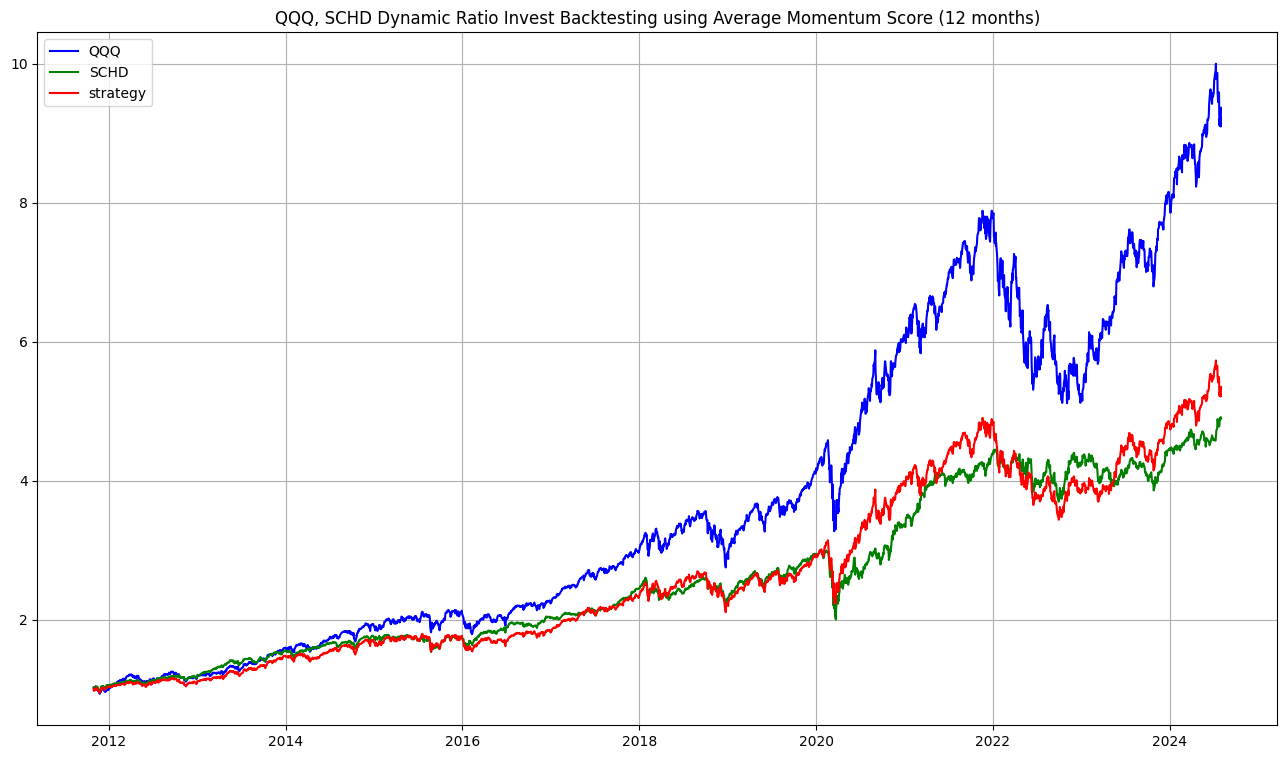

In [25]:
plt.rcParams['figure.figsize'] = (16, 9)

plt.plot(df.index, df['QQQ 주가백분율'], color = 'blue', label = p1)
plt.plot(df.index, df['SCHD 주가백분율'], color = 'green', label = p2)
plt.plot(df.index, df['전략백분율'], color = 'red', label = 'strategy')
plt.grid(True)
plt.legend(loc = 'best')

plt.title(f"{p1}, {p2} Dynamic Ratio Invest Backtesting using Average Momentum Score ({moment_months} months)")

plt.show()